(chap_bit_depths)=
# Types & bit-depths

:::{admonition} Chapter outline
:class: tip

* The **bit-depth** & **type** of an image determine what pixel values it can contain
* An image with a **higher bit-depth** can (potentially) contain **more information**
* During acquisition, most images have the type **unsigned integer**
* During processing, it's often better to use **floating point** types
* Attempting to store values outside the range permitted by the type & bit-depth leads to **clipping** -- which is usually **very bad indeed**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

As described in {ref}`chap_pixels`, each pixel has a numerical value – but a pixel cannot typically have just *any* numerical value it likes.
Instead, it works under the constraints of the image **type** and **bit-depth**.

Ultimately the pixels are stored in some binary format: a sequence of **bits** (**bi**nary digi**ts**), i.e. ones and zeros.
The bit-depth determines how many of these ones and zeros are available to store each pixel.
The type determines how these bits are interpreted.

## Representing numbers with bits

```{figure} images/bobs-code.png
---
figclass: margin
width: 60%
---
Bob devising his code.
```

Suppose Bob is developing a secret code to store numbers, but in which he is only allowed to write ones and zeros.
If he is only allowed a single one or zero (i.e. a single bit), he doesn't have many options.

Assuming he wants his encoded numbers to be consecutive integers starting from zero, this means he can only represent two different numbers: one and zero.

In [2]:
import numpy as np
import pandas as pd
n_bits = 1
df = pd.DataFrame([(ii, np.binary_repr(ii, n_bits)) for ii in range(2**n_bits)], columns=('Decimal', 'Binary'))
df.style.hide(axis='index')

Decimal,Binary
0,0
1,1


If he is allowed an extra bit, suddenly he can represent 4 numbers by combining the ones and zeros differently.

In [3]:
import numpy as np
import pandas as pd
n_bits = 2
df = pd.DataFrame([(ii, np.binary_repr(ii, n_bits)) for ii in range(2**n_bits)], columns=('Decimal', 'Binary'))
df.style.hide(axis='index')

Decimal,Binary
0,00
1,01
2,10
3,11


Clearly, the more bits Bob is allowed, the more unique combinations he can have -- and therefore the more different numbers he can represent in his code.

With 8 bits are his disposal, Bob can combine the bits in 256 different ways to represent 256 different numbers.

In [4]:
import numpy as np
import pandas as pd
n_bits = 8
df = pd.DataFrame([(ii, np.binary_repr(ii, n_bits)) for ii in range(2**n_bits)], columns=('Decimal', 'Binary'))
df.style.hide(axis='index')

Decimal,Binary
0,00000000
1,00000001
2,00000010
3,00000011
4,00000100
5,00000101
6,00000110
7,00000111
8,00001000
9,00001001


The pixel values in an image are stored using a code just like this.
Each possible value is represented in binary as a unique combination of bits.

## Image bit-depth

The **bit-depth** of an image is the number of bits used to represent each pixel.
A bit-depth of 8 would indicate that 8 bits are used to represent a single pixel value.

The bit-depth imposes a limit upon the pixel values that are possible.
A lower bit-depth implies that fewer different pixel values are available, which can result in an image that contains less information.

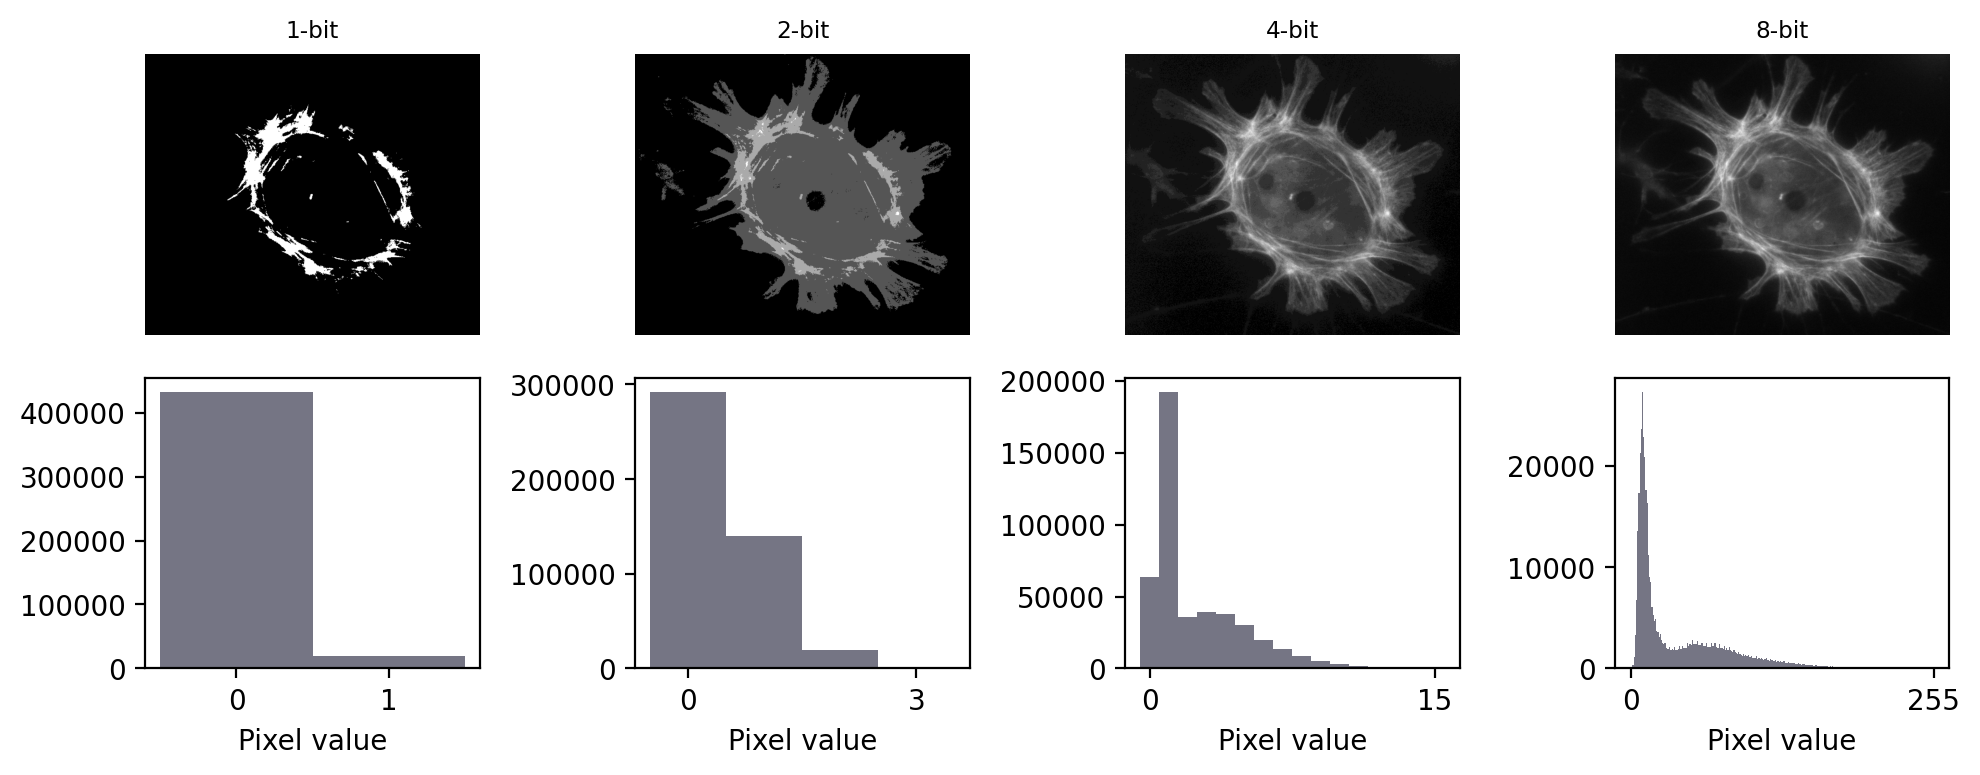

In [5]:
fig = create_figure(figsize=(10, 4))

im = load_image('sunny_cell.tif')
assert im.dtype == np.uint16

def rescale_to_bits(im: np.ndarray, n_bits: int) -> np.ndarray:
    """
    Helper method to rescale an image to have values supported with a specific bit-depth (unsigned integer).
    """
    max_value = 2**n_bits - 1
    im = im - im.min()
    im = im * (max_value / im.max())
    im = np.round(im)
    return im

# Show images converted (with rescaling) to different bit-depths
bit_depths = [1, 2, 4, 8]
n = len(bit_depths)
for ii, bits in enumerate(bit_depths):
    im_bits = rescale_to_bits(im, bits)
    show_image(im_bits, title=f"{bits}-bit", pos=(2, n, ii+1))
    show_histogram(im_bits, ylabel=None, bins=range(0, 2**bits+1), align='left', pos=(2, n, n+ii+1))
    plt.xticks([0, 2**bits-1])
#     plt.yticks([])

plt.tight_layout()
glue_fig('fig_bit_depths_demo', fig)

```{glue:figure} fig_bit_depths_demo
:name: fig-bit_depths_demo
Representing an image using different bit-depths.
```

As shown in {numref}`fig-bit_depths_demo`, a 1-bit image can contain only two values: here, shown as black or white pixels.
Such **binary images** are extremely limited in the information that they can contain, although will turn out to be [very useful later](chap_thresholding) when processing images.

A 2-bit image is not much better, containing at most only 4 different values.
A 4-bit image can have 16 values.
When visualized with a grayscale LUT, this is a substantial improvement.
In fact, the eye is not particularly good at distinguishing different shades of gray -- making it difficult to see much difference between a 4-bit and 8-bit image.
However, the histograms reveal that the 8-bit image contains more fine-grained information.

In practice, computers tend to work with groups of 8 bits, with each group of 8 bits known as a **byte**.
Microscopes that acquire 8-bit images are still reasonably common, and these permit 2<sup>8</sup> = 256 different pixel values, which fall in the range 0–255.
The next step up is a 16-bit image, which can contain 2<sup>16</sup> = 65536 values: a dramatic improvement (0–65535).

````{tab-set}

```{tab-item} Question

What impact would you expect bit-depth to have on the file size of a saved image?

For example, would you expect an 8-bit image to have a larger, smaller or (roughly) equivalent file size to a 16-bit image of the same scene?
You can assume the two images have the same number of pixels.
```

```{tab-item} Answer
In general, the file size required to store an image is expected to be higher with a higher bit-depth.

Assuming that the image isn't [compressed](sec_files_compression), a 16-bit image would require roughly twice as much storage space as a corresponding 8-bit image.

If you have a 1024 x 1024 pixel image that is 8-bit, that should take roughly 1 MB to store.
The corresponding 16-bit image would require approximately 2 MB.
```

````

(sec_bits_type)=
## Image type

At this point, you  might be wondering: what about fractions?
Or negative numbers?

In reality, the bit-depth is only part of the story.
The **type** of the image is what determines how the bits are interpreted.

Until now, we have assumed that 8 bits would be used to represent whole numbers in the range 0 -- 255, because we have 2<sup>8</sup> = 256 different combinations of 8 bits.
This is an **unsigned integer** representation.

But suppose we dedicate one of our bits to represent whether the number should be interpreted as positive or negative, with the remaining seven bits providing the magnitude of the number.
An image using this approach has the type **signed integer**.
Typically, an 8-bit signed integer can be in the range -128 -- 127.
Including 0, that still leaves 256 distinct possibilities.

Although the images we acquire are normally composed of unsigned integers, we will later explore the immense benefits of processing operations such as averaging or subtracting pixel values, in which case the resulting pixels may be negative or contain fractional parts.
**Floating point** type images make it possible to store these new, not-necessarily-integer values in an efficient way.
That can be important, because we could lose a lot of information if we always had to round pixel values to integers.

Floating point images also allow us to store three special values: $+\infty$, $-\infty$ and `NaN`.
The last of these stands for *Not a Number*, and can represent a missing or impossible value, e.g. the result of 0/0.

```{admonition} Key message
:class: tip

The bit-depth and type of an image determine what pixel values are possible.
```

```{admonition} How & why points can float

Floating point pixel values have variable precision depending upon whether they are representing very small or very large numbers.

Representing a number in binary using floating point is analogous to writing it out in standard form, i.e. something like 3.14×10<sup>8</sup>, which may be written as 3.14e8.
In this case, we have managed to represent 314000000 using only 4 digits: 314 and 8 (the 10 is already baked in to the representation).

In the binary case, the form is more properly something like ± 2<sup>**M**</sup>×N: we have one bit devoted to the sign, a fixed number of additional bits for the exponent *M*, and the rest to the main number *N* (called the fraction).

A 32-bit floating point number typically uses 1 bit for the sign, 8 bits for the exponent and 23 bits for the fraction, allowing us to store a very wide range of positive and negative numbers.
A 64-bit floating point number uses 1 bit for the sign, 11 bits for the exponent and 52 for the fraction, thereby allowing both an even wider range and greater precision.
But again these require more storage space than 8- and 16-bit images.

```


```{admonition} Common image types & bit-depths
Lots of permutations of bit-depth and type are possible, but in practice three are most common for images:
* 8-bit unsigned integer
* 16-bit unsigned integer
* 32-bit floating point

The representations above are sufficiently ubiquitous that the type is often assumed.
Unless otherwise specified, any 8-bit or 16-bit image is most likely to use unsigned integers, while a 32-bit image is probably using floating point pixels.

Conceivably you *can* have a 32-bit signed/unsigned integer image, or even a 16-bit floating point image, but these are less common in the wild.
```


````{margin}
```{image} images/pixel_types.png
:align: right
```
````

`````{tab-set}

````{tab-item} Question


The pixels shown on the right all belong to different images.

In each case, identify what *possible* type an image could have in order to represent the value of the pixel.
There can be more than one possible type for each pixel.

Your type options are:

* Signed integer
* Unsigned integer
* Floating point
````

````{tab-item} Answer
The possible image types, from left to right:

1.  Signed integer or floating point
2.  Unsigned integer, signed integer or floating point
3.  Floating point

Note that 'floating point' is an option in all cases: it's the most flexible representation.
````

`````

````{tab-set}

```{tab-item} Question

What is the maximum pixel value that can be stored in a *16-bit, unsigned integer* image?
```

```{tab-item} Answer
The maximum value that can be stored in a 16-bit, unsigned integer image is 2<sup>16</sup>-1 = 65535.
```

````

````{tab-set}

```{tab-item} Question

What would be the maximum pixel value that can be stored in a *16-bit, signed integer* image?
```

```{tab-item} Answer
The maximum value that can be stored in a 16-bit, signed integer image is 2<sup>15</sup>-1 = 32767 (since one of the bits is used for the sign, we have 15 remaining).
```

````

In [6]:
im = load_image('sunny_cell.tif')
im = im.astype(np.float32) - im.min() / (im.max() - im.min()) * 255
im = im.astype(np.uint8)

n_cols = 8
n_rows = 8

row = im[len(im)//2, :n_rows*n_cols]
binary_pixels = [np.binary_repr(p, width=8) for p in row]

binary_string = ''.join(binary_pixels) + '...'
glue("binary_string", binary_string)

'00011001000111110010111100111101001000000010000000011010001000000010001100101110001001000010100000101010010010000011001000011000001001000100001000111011001010110001111000100110000111010100000100110100000111100011001000100100001111000010101000110001001000010010001001001110010000110001011100100011001101000011001100110111001010100011111001010011001011110010100000110000001010100011111100111010010010100100011001010000001111010101111101011101011011000101010110010100101011011110110000111110010001110100111000101101...'

:::{admonition} An image as a matrix of numbers, or just ones and zeros?

You may recall how {numref}`fig-image_array` showed an image as being a matrix of numbers.
That is already a slightly high level abstraction of how the image is actually represented.
It's more accurate to see the image (or, indeed, any digital data) as simply being a long stream of ones and zeros, such as

{glue:}`binary_string`

More information is needed about how the pixel values of the image are encoded to interpret these ones and zeros.
This includes how should the ones and zeros be split up to represent different values (e.g. in chunks of 8, 16, or some other number?).

The bit-depth is what tells us how big the chunks are, and the type tells us how to convert each chunk into a decimal number.
:::

## When bits go bad

We're now ready to discuss why you absolutely do need to know the basics of bit-depths and image types when working with scientific images.

The main point of {ref}`chap_pixels` is that we need to
keep control of our pixel values so that our final analysis is justifiable.
There are two main bit-related things that can go wrong when trying to store a pixel value in an image:

1.  **Clipping:** We try to store a number outside the range supported, so that the closest valid value is stored instead. For example, if we try to store -10 in an 8-bit unsigned integer image then the closest value we can actually store is 0. Similarly, if we try to store 500 then the closest valid value is 255.
2.  **Rounding:** We try to store a number that cannot be represented exactly, and so it must be rounded to the closest possible value. For example, if we want to store 6.4 in an 8-bit unsigned integer image then this is not possible; rather, we would need to store 6 instead.


(sec_bit_depths_clipping)=
### Data clipping

Of the two problems, clipping is usually the more serious, as shown in {numref}`fig-bits_clipping`.
A clipped image contains pixels with values equal to the maximum or minimum supported by that bit-depth, and it's no longer possible to tell what values those pixels *should* have.
**The information is irretrievably lost.**

Clipping often occurs whenever an image is converted to have a lower bit-depth.
During this conversion, not all the original pixel values may be preserved -- in which case they must be somehow transformed into the range permitted by the output bit-depth.

This transformation could simply involve clipping the unsupported values (usually very bad), or it could involve rescaling the pixel values first (usually less bad).

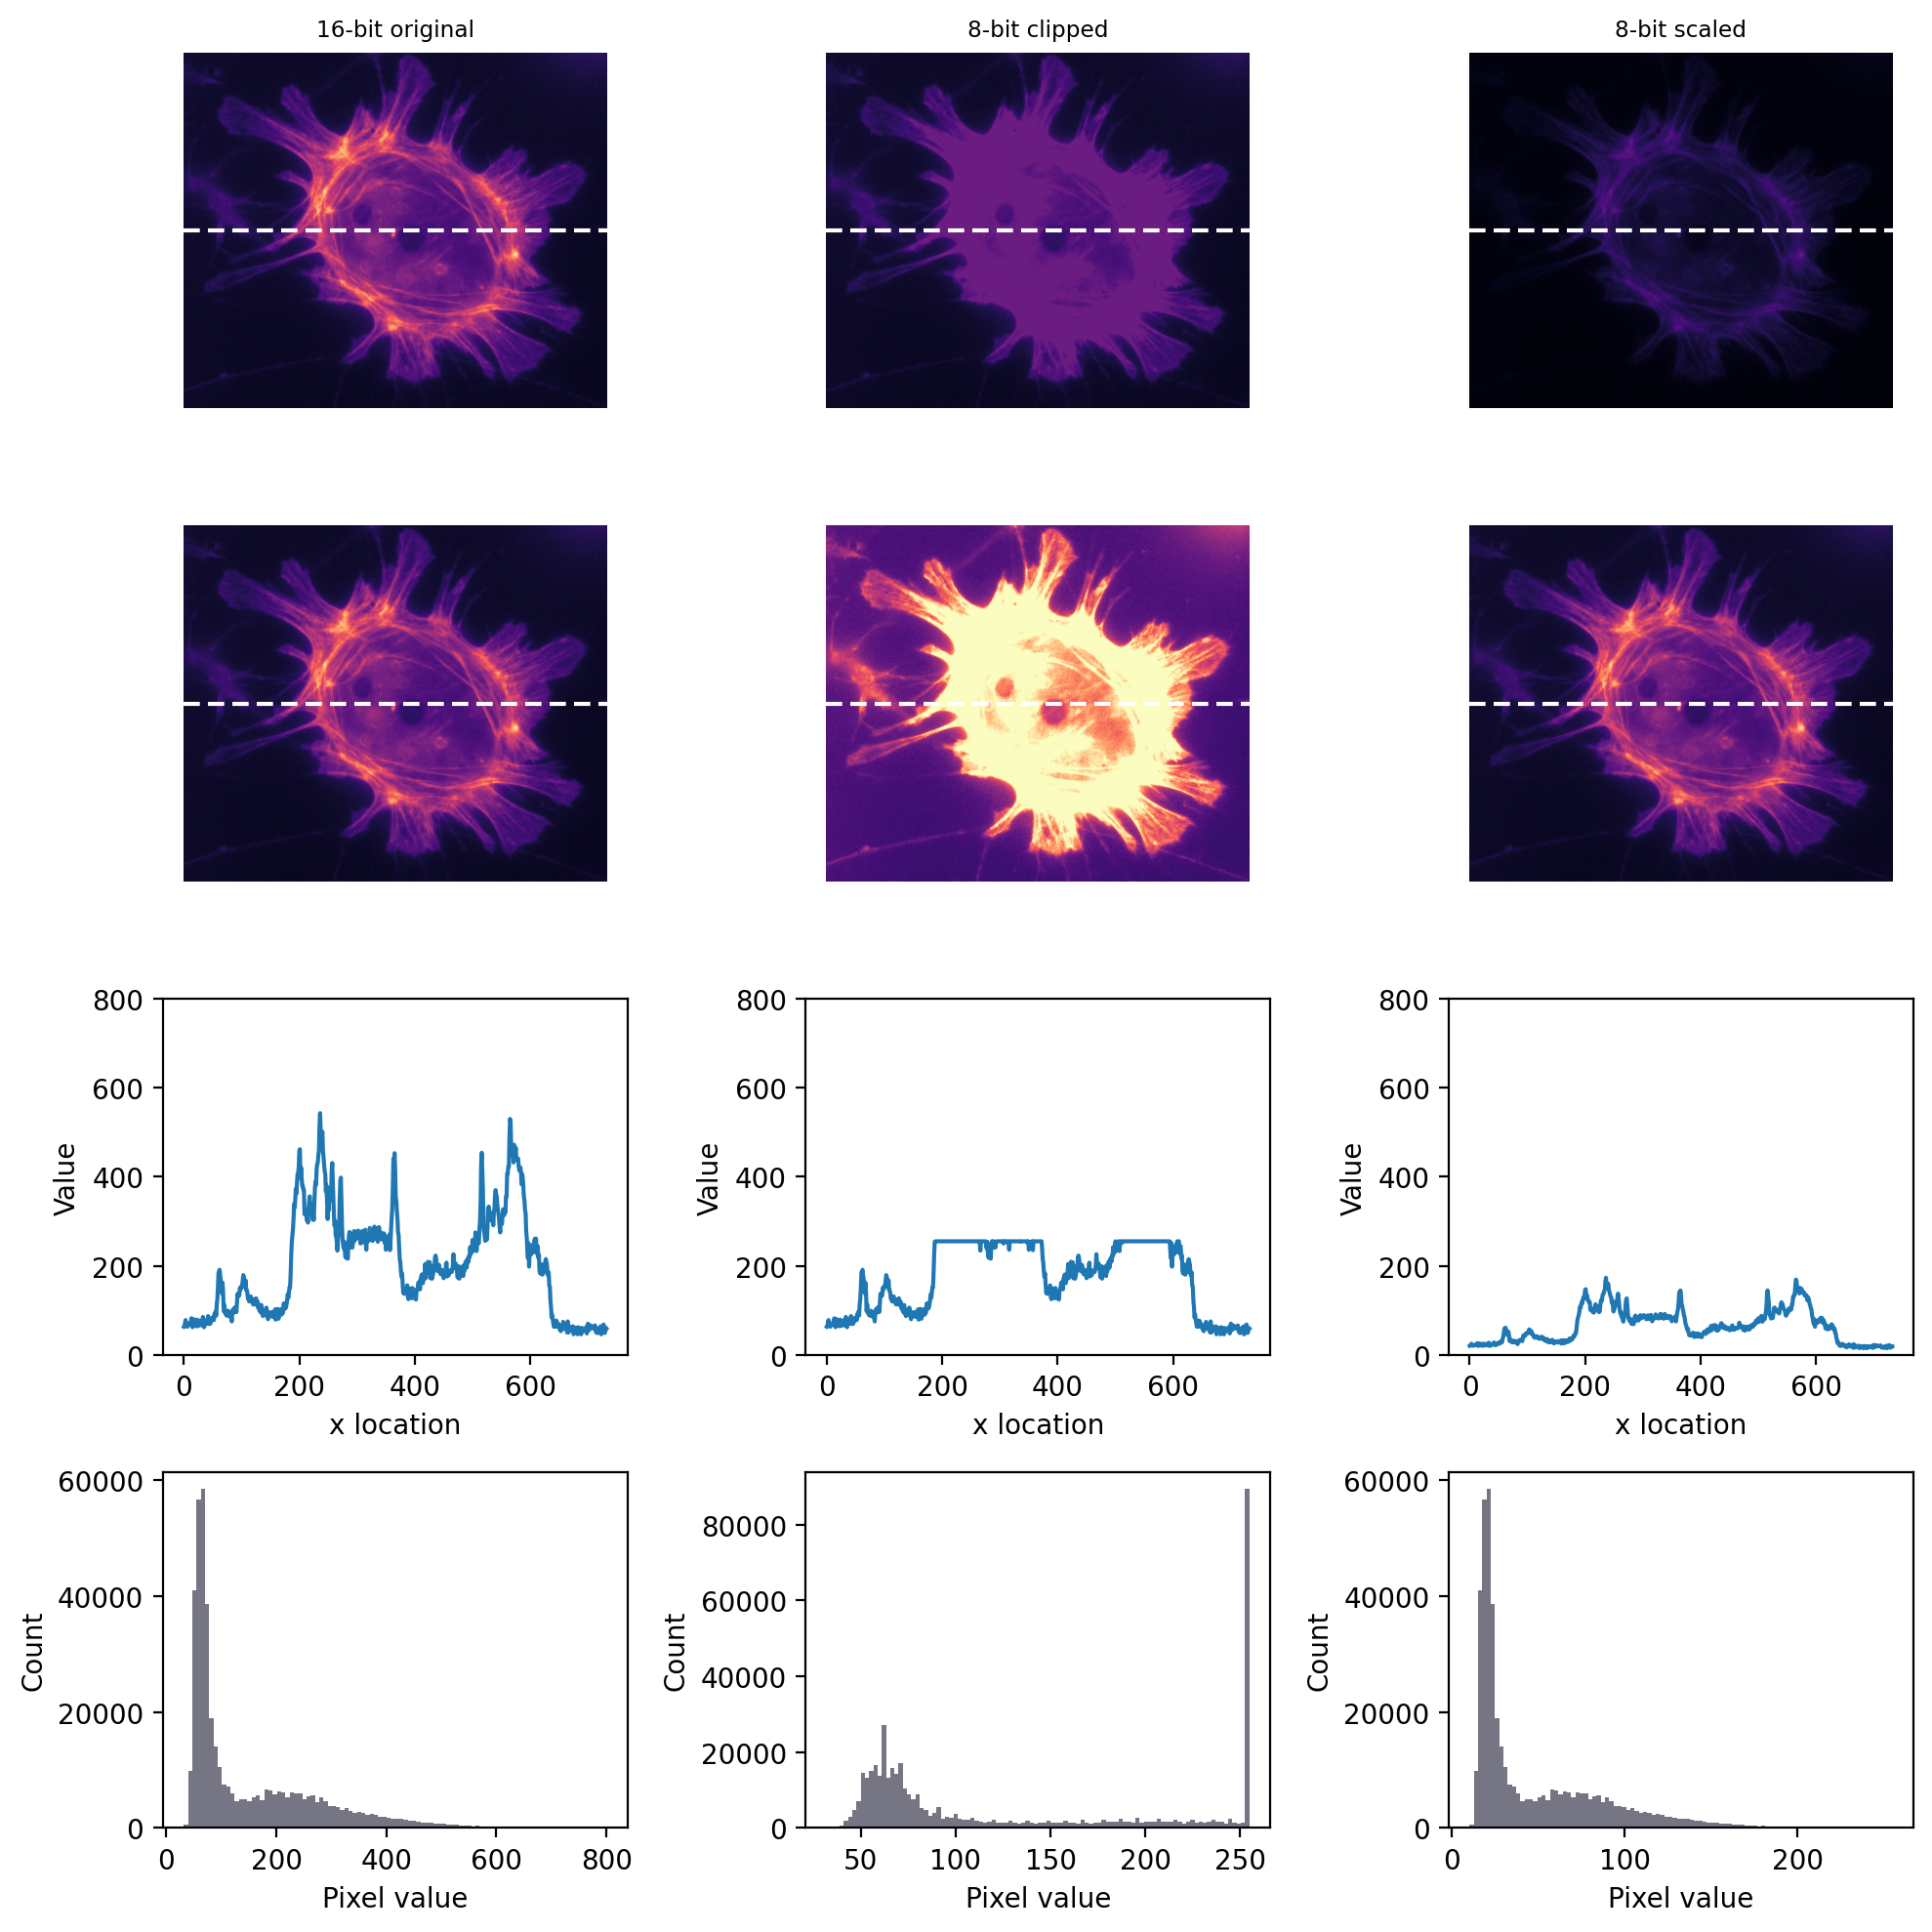

In [7]:
fig =  create_figure(figsize=(10, 10))

im = load_image('sunny_cell.tif')

# Define the maximum in the 16-bit image (so that it more clearly illustrates the concepts we want to show...)
# (Reader, please ignore this!)
max_value = 800
min_value = 32
im = im.astype(np.float32)
im = im - im.min()
im = im / im.max()
im = im * (max_value - min_value) + min_value
im = im.astype(np.uint16)

# Define colormap & display range
cmap = 'magma'
row = im.shape[0]//2
# vmax = np.percentile(im, 99)
vmax = im.max()
hist_params = dict(bins=100)
line_params = dict(y=row, color=(1, 1, 1), dashes=(4, 2))

# Original image
show_image(im, vmin=0, vmax=vmax, cmap=cmap, title="16-bit original", pos=431)
plt.axhline(**line_params)
show_image(im, vmin=0, vmax=im.max(), cmap=cmap, pos=434)
plt.axhline(**line_params)

plt.subplot(4, 3, 7)
prof_rescaled = im[row, :]
plt.plot(prof_rescaled)
plt.xlabel('x location')
plt.ylabel('Value')
plt.ylim(0, max_value)

show_histogram(im, **hist_params, pos=(4,3,10))

# Clipped to 255
im_clipped = np.clip(im, 0, 255)
show_image(im_clipped, vmin=0, vmax=vmax, cmap=cmap, title="8-bit clipped", pos=432)
plt.axhline(**line_params)
show_image(im_clipped, vmin=0, vmax=im_clipped.max(), cmap=cmap, pos=435)
plt.axhline(**line_params)

plt.subplot(4, 3, 8)
prof_rescaled = im_clipped[row, :]
plt.plot(prof_rescaled)
plt.xlabel('x location')
plt.ylabel('Value')
plt.ylim(0, max_value)

show_histogram(im_clipped, **hist_params, pos=(4,3,11))

# Rescaled, then clipped to 255
im_rescaled = np.clip(im*(255.0/im.max()), 0, 255)
show_image(im_rescaled, vmin=0, vmax=vmax, cmap=cmap, title="8-bit scaled", pos=433)
plt.axhline(**line_params)
show_image(im_rescaled, vmin=0, vmax=im_rescaled.max(), cmap=cmap, pos=436)
plt.axhline(**line_params)

plt.subplot(4, 3, 9)
prof_rescaled = im_rescaled[row, :]
plt.plot(prof_rescaled)
plt.xlabel('x location')
plt.ylabel('Value')
plt.ylim(0, max_value)

show_histogram(im_rescaled, **hist_params, pos=(4,3,12))

plt.tight_layout()

glue_fig("clipping_fig", fig)

```{glue:figure} clipping_fig
:figwidth: 90%
:name: "fig-bits_clipping"

Storing an image using a lower bit-depth, either by clipping or by scaling the values.
The top row shows all images with the same minimum and maximum values to determine the contrast, while the second row shows shows the same images with the maximum set to the highest pixel value actually present (the images are the same, only the LUTs are different).
The bottom rows show both a plot of the pixel values through the center of each image and histograms of all the image pixel values.
One may infer that information has been lost in both of the 8-bit images, but more much horrifically when clipping was applied.
Scaling squeezes the data into a narrow range, which might result in some rounding errors -- but most of the information remains intact, with the shapes of the profile plot and histogram remaining similar.
```

```{margin}
Clipping of high pixel values during acquisition is also called **saturation**.
```

However, it's important to know that **clipping can already occur during image acquisition**.
In fluorescence microscopy, this depends upon three main factors:

1.  **The amount of light being emitted.** Because pixel values depend upon how much light is detected, a sample emitting very little light is less likely to require the ability to store very large values. Although it still *might* because of...
2.  **The gain of the microscope.** Quantifying very tiny amounts of light accurately has practical difficulties. A microscope’s gain effectively amplifies the amount of detected light to help overcome this before turning it into a pixel value (see {ref}`chap_microscope_types`). However, if the gain is too high, even a small number of detected photons could end up being over-amplified until clipping occurs.
3.  **The offset of the microscope.** This effectively acts as a constant being added to every pixel. If this is too high, or even negative, it can also push the pixels outside the permissible range.

```{admonition} Avoid clipping your data!
:class: danger

If clipping occurs, we no longer know what is happening in the brightest or darkest parts of the image -- which can thwart any later analysis.
Therefore **during image acquisition, any available controls should be adjusted to make sure clipping is avoided.**
```


% TODO: ADD HISTOGRAMS, ASK WHERE THERE IS CLIPPING

% TODO: IMAGEJ'S BLOBS SAMPLE IMAGE HAS A CURIOUS HISTOGRAM. LOOKING AT IT, CAN YOU TELL WHAT HAS HAPPENED?
% - RESCALED TO A LOWER BIT-DEPTH, RESCALED TO A HIGHER BIT-DEPTH, CLIPPED


````{tab-set}

```{tab-item} Question

When acquiring an 8-bit unsigned integer image, is it fair to say your data is fine so long as your minimum pixel value is 0 and your maximum value is 255?
```

```{tab-item} Answer
No! At least, not really.

You *cannot* store pixels outside the range 0–255.
If your image contains pixels with either of those extreme values, *you cannot be certain whether or not clipping has occurred*.
Therefore, you should ensure images you acquire do not contain any pixels with the most extreme values permitted by the image bit-depth.
To be confident your 8-bit data is not clipped, the maximum range would be 1–254.
```

````

````{tab-set}

```{tab-item} Question

The bit-depth of an image is probably some multiple of 8, but the bit-depth that a [detector (e.g. CCD)](chap_microscope_types) can support might not be.

For example, what is the maximum value in a 16-bit image that was acquired using a camera with a 12-bit output?

And what is the maximum value in a 8-bit image acquired using a camera with a 14-bit output?

Assume unsigned integers are used in both cases.
```

```{tab-item} Answer
The maximum value of a 16-bit image obtained using a 12-bit camera is 4095 (i.e. 2<sup>12</sup>-1).

The maximum value of an 8-bit image obtained using a 14-bit camera is 255 – the extra bits of the camera do not change this.
But if the image was saved in 16-bit instead, the maximum value would be 16383.

So be aware that the actual range of possible values depends upon the acquisition equipment as well as the bit-depth of the image itself.
The lower bit-depth will dominate.
```

````

### Rounding errors

Rounding is a more subtle problem than clipping.
Again it is relevant as early as acquisition.

For example, suppose you are acquiring an image in which there really are 1000 distinct and quantifiable levels of light being emitted from different parts of a sample.
These could not possibly be given different pixel values within an 8-bit image, but could normally be fit into a 16-bit or 32-bit image with lots of room to spare.
If our image is 8-bit, and we want to avoid clipping, then we would need to scale the original photon counts down first – resulting in pixels with different photon counts being rounded to have the same values, and their original differences being lost.

Nevertheless, rounding errors during acquisition are usually small: it may not *really* matter if we can't tell the difference between detecting 1,000 photons and 1,003 photons.

Rounding can be a bigger problem when it comes to processing operations like filtering, which often involve computing averages over many pixels (see {ref}`chap_filters`).
The good news is that at this post-acquisition stage we can convert our data to floating point and then get fractions if we need them.

:::{admonition} Floating point rounding errors
:class: info

As a full disclosure, I should admit that using floating point types is only a partial solution to rounding issues.
Even a 64-bit floating point image cannot store all useful pixel values with perfect precision, and seemingly straightforward numbers like 0.1 are only imprecisely represented.

But this is not really unexpected: this binary limitation is similar to how we cannot write 1/3 in decimal exactly.
We can write 0.3333333 but our level of precision will depend upon our willingness to continue adding 3’s after the decimal point.

In any case, rounding 0.1 to 0.100000001490116119384765625 (a possible floating point representation) is not so bad as rounding it to 0 (an integer representation), and the imprecisions of floating point numbers in image analysis are *usually* small enough to be disregarded.

See <https://xkcd.com/217/> for more information.
:::


:::{admonition} More bits are better (usually)
:class: tip

From considering both clipping and rounding, the simple rule of bit-depths emerges: if you want the maximum information and precision in your images, more bits are better.
This is depicted in {numref}`fig-blocks_and_bits`.

When given the option of acquiring a 16-bit or 8-bit image, most of the time you should opt for the former.


  ```{figure} images/blocks_and_bits.jpg
  ---
  align: center
  name: fig-blocks_and_bits
  ---
  **Illustration of the comparative accuracy of *(left to right)* 8-bit, 16-bit and 32-bit images.**
  If an 8-bit image is like creating a sculpture out of large building blocks, a 16-bit image is more like using Lego and a 32-bit floating point image resembles using clay.
  Anything that can be created with the blocks can also be made from the Lego; anything made from the Lego can also be made from the clay.
  This does not work in reverse: some complex creations can only be represented properly by clay, and building blocks permit only a crude approximation at best.
  On the other hand, if you only need something blocky, it’s not really worth the extra effort of Lego or clay.
  And, from a very great distance, it might be hard to tell the difference.
  ```

:::

````{tab-set}

```{tab-item} Question
Although *more bits are better* is a simple rule of thumb we can share with those who do not know the subtleties of bit-depths, it should not be held completely rigorously.

Can you think of any circumstances when more bits might *not* be better?
```

```{tab-item} Answer
Reasons why a lower bit depth is *sometimes* preferable to a higher one include:

* A higher bit-depth leads to larger file sizes, and potentially slower processing. For very large datasets, this might be a bigger issue that any loss of precision found in using fewer bits.
* The amount of light detected per pixel might be so low that thousands of possible values are not required for its accurate storage, and 8-bits (or even fewer) would be enough. For the light-levels in biological fluorescence microscopy, going beyond 16-bits would seldom bring any benefit.

But with smallish datasets for which processing and storage costs are not a problem, it is safest to err on the side of more bits than we strictly need.
```

````